----TRAIN DATA-------
   parcelid  logerror transactiondate
0  11016594    0.0276      2016-01-01
1  14366692   -0.1684      2016-01-01
2  12098116   -0.0040      2016-01-01
3  12643413    0.0218      2016-01-02
4  14432541   -0.0050      2016-01-02
5  11509835   -0.2705      2016-01-02
6  12286022    0.0440      2016-01-02
7  17177301    0.1638      2016-01-02
8  14739064   -0.0030      2016-01-02
9  14677559    0.0843      2016-01-03
----PROPERTY DATA-------
   parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  12027388                    1.0                       NaN           NaN   
1  12029288                    1.0                       NaN           NaN   
2  12035796                    NaN                       NaN           NaN   
3  12037477                    NaN                       NaN           NaN   
4  12062316                    1.0                       NaN           NaN   
5  17073783                    NaN                       NaN       

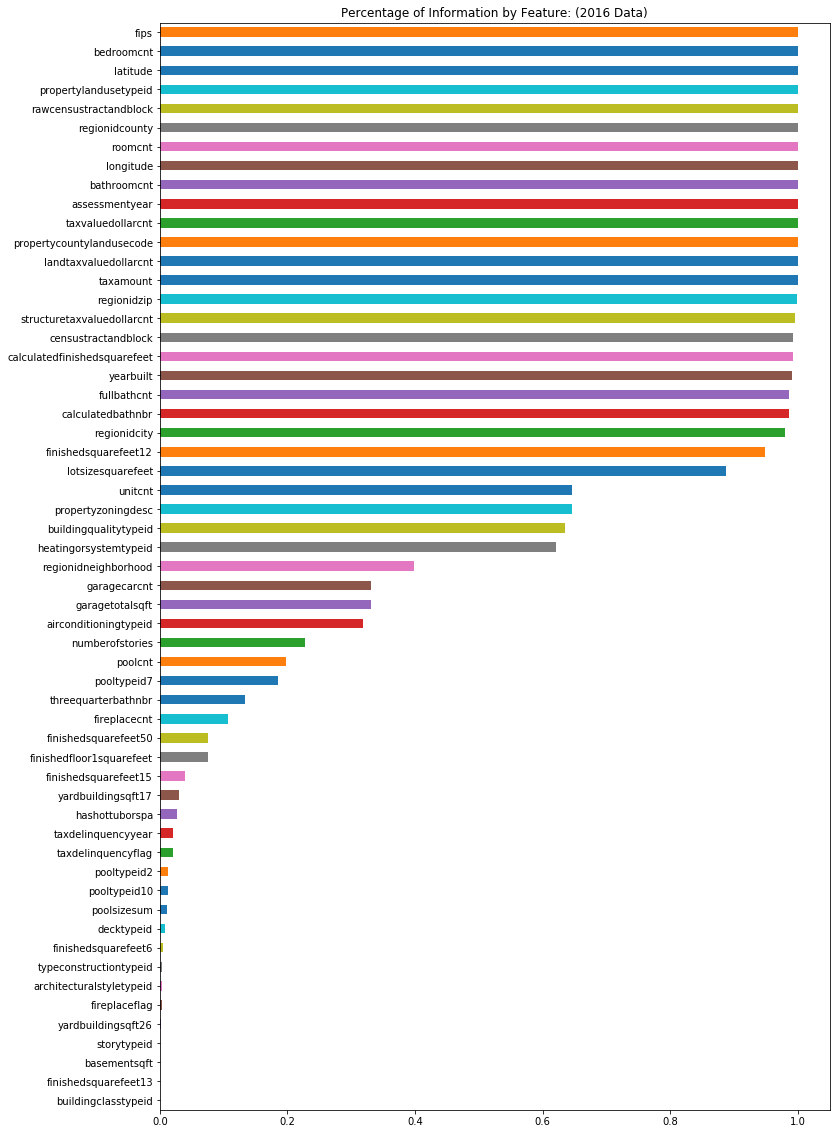

(90527, 43) (90527,)
------PREDICTED VALUES --------
[-0.0471 -0.0377  0.009  ...  0.0198  0.0305 -0.0336]
------MEAN ABSOLUTE ERROR --------
0.11325477349472772
ACCURACY SCORE
---------------------------------------
-1.0877286821026675


In [52]:
##### ENVIRONMENT SETUP ########

import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.stats as stats
from scipy.stats import norm
#import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor

pd.options.display.max_columns = 999

##### TRAINING DATA ############

train_data = pd.read_csv('data/train_2016_v2.csv', parse_dates =["transactiondate"])
print("----TRAIN DATA-------")
print(train_data.head(10))
train_data.head(10)

##### PROPERTY DATA ############

property_data = pd.read_csv('data/2016DATA.csv')
print("----PROPERTY DATA-------")
print(property_data.head(10))
property_data.head(10)
# print property_data.dtypes

##### Visualize and Clean Data #####

plt.figure(figsize=(12,20))
property_data.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = True).plot(kind = 'barh')
plt.title('Percentage of Information by Feature: (2016 Data)')
plt.show()
property_data.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = False)

##### Pools & Hot tubs ##########

# "0 pools"
property_data.poolcnt.fillna(0,inplace = True)
# "0 hot tubs or spas"
property_data.hashottuborspa.fillna(0,inplace = True)
# Convert "True" to 1
property_data.hashottuborspa.replace(to_replace = True, value = 1,inplace = True)
# print property_data['hashottuborspa'].value_counts()

# Set properties that have a pool but no info on poolsize equal to the median poolsize value.
property_data.loc[property_data.poolcnt==1, 'poolsizesum'] = property_data.loc[property_data.poolcnt==1, 'poolsizesum'].fillna(property_data[property_data.poolcnt==1].poolsizesum.median())
# "0 pools" = "0 sq ft of pools"
property_data.loc[property_data.poolcnt==0, 'poolsizesum']=0
# "0 pools with a spa/hot tub"
property_data.pooltypeid2.fillna(0,inplace = True)
# "0 pools without a hot tub"
property_data.pooltypeid7.fillna(0,inplace = True)
# Drop redundant feature
property_data.drop('pooltypeid10', axis=1, inplace=True)
property_data.head()

##### Fireplace Data ##########

# print property_data['fireplaceflag'].value_counts()
# If "fireplaceflag" is "True" and "fireplacecnt" is "NaN", we will set "fireplacecnt" equal to the median value of "1".
property_data.loc[(property_data['fireplaceflag'] == True) & (property_data['fireplacecnt'].isnull()), ['fireplacecnt']] = 1
# If 'fireplacecnt' is "NaN", replace with "0"
property_data.fireplacecnt.fillna(0,inplace = True)
# If "fireplacecnt" is 1 or larger "fireplaceflag" is "NaN", we will set "fireplaceflag" to "True".
property_data.loc[(property_data['fireplacecnt'] >= 1.0) & (property_data['fireplaceflag'].isnull()), ['fireplaceflag']] = True
property_data.fireplaceflag.fillna(0,inplace = True)
# print property_data['fireplaceflag'].value_counts()
# Convert "True" to 1
property_data.fireplaceflag.replace(to_replace = True, value = 1,inplace = True)
# print property_data['fireplaceflag'].value_counts()

##### Garage Data ##########

property_data.garagecarcnt.fillna(0,inplace = True)
property_data.garagetotalsqft.fillna(0,inplace = True)

##### Tax Data Delinquency ##########

#print property_data['taxdelinquencyflag'].value_counts()
# Replace "NaN" with "0"
property_data.taxdelinquencyflag.fillna(0,inplace = True)
# Change "Y" to "1"
property_data.taxdelinquencyflag.replace(to_replace = 'Y', value = 1,inplace = True)
# print property_data['taxdelinquencyflag'].value_counts()
# Drop "taxdelinquencyyear"
property_data.drop('taxdelinquencyyear', axis=1, inplace=True)

##### The Rest ##########

# Drop "storytypeid"
property_data.drop('storytypeid', axis=1, inplace=True)
# Replace "NaN" with 0, signifying no basement.
property_data.basementsqft.fillna(0,inplace = True)
#print(property_data['yardbuildingsqft26'].value_counts())
# Replace 'yardbuildingsqft26' "NaN"s with "0".
property_data.yardbuildingsqft26.fillna(0,inplace = True)
# Drop "architecturalstyletypeid"
property_data.drop('architecturalstyletypeid', axis=1, inplace=True)
# Drop "typeconstructiontypeid" and "finishedsquarefeet13"
property_data.drop('typeconstructiontypeid', axis=1, inplace=True)
property_data.drop('finishedsquarefeet13', axis=1, inplace=True)
# Drop "buildingclasstypeid"
property_data.drop('buildingclasstypeid', axis=1, inplace=True)
#print property_data.shape
property_data.notnull().mean().sort_values(ascending = False)
# Let's check the unique values for "decktypeid"
# print(property_data['decktypeid'].value_counts())
# Change "decktypeid" "Nan"s to "0"
property_data.decktypeid.fillna(0,inplace = True)
# Convert "decktypeid" "66.0" to "1"
property_data.decktypeid.replace(to_replace = 66.0, value = 1,inplace = True)
# print(property_data['decktypeid'].value_counts())
# print(property_data['finishedsquarefeet6'].value_counts())

#squarefeet = property_data[property_data['finishedsquarefeet6'].notnull() & property_data['finishedsquarefeet12'].isnull() & property_data['finishedsquarefeet15'].isnull() & property_data['finishedsquarefeet50'].isnull() & property_data['lotsizesquarefeet'].isnull()]
#squarefeet = property_data[property_data['finishedsquarefeet12'].notnull() & property_data['finishedsquarefeet15'].notnull() & property_data['finishedsquarefeet50'].notnull() & property_data['lotsizesquarefeet'].notnull()]
squarefeet = property_data[property_data['finishedsquarefeet15'].notnull() & property_data['finishedsquarefeet50'].notnull() & property_data['lotsizesquarefeet'].notnull()]
squarefeet[['calculatedfinishedsquarefeet','finishedsquarefeet6','finishedsquarefeet12','finishedsquarefeet15','finishedsquarefeet50','numberofstories','lotsizesquarefeet','landtaxvaluedollarcnt','structuretaxvaluedollarcnt','taxvaluedollarcnt','taxamount']]
#squarefeet
# squarefeet = property_data[property_data[['finishedsquarefeet6','finishedsquarefeet12','finishedsquarefeet15','finishedsquarefeet50','lotsizesquarefeet']].notnull()]
#property_data[['finishedsquarefeet6','finishedsquarefeet12','finishedsquarefeet15','finishedsquarefeet50','lotsizesquarefeet']][:100]

# Drop "finishedsquarefeet6"
property_data.drop('finishedsquarefeet6', axis=1, inplace=True)
# Drop "finishedsquarefeet12"
property_data.drop('finishedsquarefeet12', axis=1, inplace=True)
# Drop "finishedfloor1squarefeet"
property_data.drop('finishedfloor1squarefeet', axis=1, inplace=True)

squarefeet2 = property_data[property_data['finishedsquarefeet15'].notnull() & property_data['finishedsquarefeet50'].notnull() & property_data['lotsizesquarefeet'].notnull()]
#squarefeet2 = property_data[property_data['finishedsquarefeet15'].notnull() & property_data['calculatedfinishedsquarefeet'].isnull()]
squarefeet2[['calculatedfinishedsquarefeet','finishedsquarefeet15','finishedsquarefeet50','numberofstories','lotsizesquarefeet']]
property_data.notnull().mean().sort_values(ascending = False)

# Replace "NaN" "calculatedfinishedsquarefeet" values with mean.
property_data['calculatedfinishedsquarefeet'].fillna((property_data['calculatedfinishedsquarefeet'].mean()), inplace=True)

# Replace "NaN" "finishedsquarefeet15" values with calculatedfinishedsquarefeet.
property_data.loc[property_data['finishedsquarefeet15'].isnull(),'finishedsquarefeet15'] = property_data['calculatedfinishedsquarefeet']
#property_data['finishedsquarefeet15'].fillna(property_data['calculatedfinishedsquarefeet'])

property_data.numberofstories.fillna(1,inplace = True)
property_data.notnull().mean().sort_values(ascending = False)
# print(property_data['numberofstories'].value_counts())

# If "numberofstories" is equal to "1", then we can replace the "NaN"s with the "calculatedfinishedsquarefeet" value. Fill in the rest with the average values.
property_data.loc[property_data['numberofstories'] == 1.0,'finishedsquarefeet50'] = property_data['calculatedfinishedsquarefeet']
property_data['finishedsquarefeet50'].fillna((property_data['finishedsquarefeet50'].mean()), inplace=True)

# print property_data.shape
property_data.notnull().mean().sort_values(ascending = False)

# Replace 'yardbuildingsqft17' "NaN"s with "0".
property_data.yardbuildingsqft17.fillna(0,inplace = True)

bathrooms = property_data[property_data['fullbathcnt'].notnull() & property_data['threequarterbathnbr'].notnull() & property_data['calculatedbathnbr'].notnull()]
bathrooms[['fullbathcnt','threequarterbathnbr','calculatedbathnbr']]

# Drop "threequarterbathnbr"
property_data.drop('threequarterbathnbr', axis=1, inplace=True)
# Drop "fullbathcnt"
property_data.drop('fullbathcnt', axis=1, inplace=True)
# Fill in "NaN" "calculatedbathnbr" with most common
bathroommode = property_data['calculatedbathnbr'].value_counts().idxmax()
property_data['calculatedbathnbr'] = property_data['calculatedbathnbr'].fillna(bathroommode)

# print property_data.shape
property_data.notnull().mean().sort_values(ascending = False)
property_data.airconditioningtypeid.fillna(5,inplace = True)

# Drop "regionidneighborhood"
property_data.drop('regionidneighborhood', axis=1, inplace=True)
property_data.heatingorsystemtypeid.fillna(13,inplace = True)
# print(property_data['buildingqualitytypeid'].value_counts())

# Fill in "NaN" "buildingqualitytypeid" with most common
buildingqual = property_data['buildingqualitytypeid'].value_counts().idxmax()
property_data['buildingqualitytypeid'] = property_data['buildingqualitytypeid'].fillna(buildingqual)

property_data.unitcnt.fillna(1,inplace = True)
# print(property_data['propertyzoningdesc'].value_counts())

# Fill in "NaN" "propertyzoningdesc" with most common
propertyzoningdesc = property_data['propertyzoningdesc'].value_counts().idxmax()
property_data['propertyzoningdesc'] = property_data['propertyzoningdesc'].fillna(propertyzoningdesc)
property_data['lotsizesquarefeet'].fillna((property_data['lotsizesquarefeet'].mean()), inplace=True)

# print(property_data['censustractandblock'].value_counts())
# print(property_data['rawcensustractandblock'].value_counts())

# Drop "censustractandblock"
property_data.drop('censustractandblock', axis=1, inplace=True)
property_data.landtaxvaluedollarcnt.fillna(0,inplace = True)
property_data.structuretaxvaluedollarcnt.fillna(0,inplace = True)
property_data['taxvaluedollarcnt'].fillna((property_data['taxvaluedollarcnt'].mean()), inplace=True)

property_data['taxpercentage'] = property_data['taxamount'] / property_data['taxvaluedollarcnt']
property_data.head()
property_data['taxpercentage'].fillna((property_data['taxpercentage'].mean()), inplace=True)

# Drop "taxamount"
property_data.drop('taxamount', axis=1, inplace=True)
# Drop "regionidcity"
property_data.drop('regionidcity', axis=1, inplace=True)

# Fill in "NaN" "yearbuilt" with most common
yearbuilt = property_data['yearbuilt'].value_counts().idxmax()
property_data['yearbuilt'] = property_data['yearbuilt'].fillna(yearbuilt)


#print property_data.shape
#print property_data.dtypes
property_data.notnull().mean().sort_values(ascending = False)

# Fill in "fips" "NaN"s
fips = property_data['fips'].value_counts().idxmax()
property_data['fips'] = property_data['fips'].fillna(fips)

# Fill in "propertylandusetypeid" "NaN"s
propertylandusetypeid = property_data['propertylandusetypeid'].value_counts().idxmax()
property_data['propertylandusetypeid'] = property_data['propertylandusetypeid'].fillna(propertylandusetypeid)

# Drop 'regionidcounty'
property_data.drop('regionidcounty', axis=1, inplace=True)

# Fill in "latitude" "NaN"s
latitude = property_data['latitude'].value_counts().idxmax()
property_data['latitude'] = property_data['latitude'].fillna(latitude)

# Fill in "longitude" "NaN"s
longitude = property_data['longitude'].value_counts().idxmax()
property_data['longitude'] = property_data['longitude'].fillna(longitude)


# Fill in "rawcensustractandblock" "NaN"s
rawcensustractandblock = property_data['rawcensustractandblock'].value_counts().idxmax()
property_data['rawcensustractandblock'] = property_data['rawcensustractandblock'].fillna(rawcensustractandblock)

# Fill in "assessmentyear" "NaN"s
assessmentyear = property_data['assessmentyear'].value_counts().idxmax()
property_data['assessmentyear'] = property_data['assessmentyear'].fillna(assessmentyear)

# Fill in "bedroomcnt" "NaN"s
bedroomcnt = property_data['bedroomcnt'].value_counts().idxmax()
property_data['bedroomcnt'] = property_data['bedroomcnt'].fillna(bedroomcnt)

# Fill in "bathroomcnt" "NaN"s
bathroomcnt = property_data['bathroomcnt'].value_counts().idxmax()
property_data['bathroomcnt'] = property_data['bathroomcnt'].fillna(bathroomcnt)

# Fill in "roomcnt" "NaN"s
roomcnt = property_data['roomcnt'].value_counts().idxmax()
property_data['roomcnt'] = property_data['roomcnt'].fillna(roomcnt)

# Fill in "propertycountylandusecode" "NaN"s
propertycountylandusecode = property_data['propertycountylandusecode'].value_counts().idxmax()
property_data['propertycountylandusecode'] = property_data['propertycountylandusecode'].fillna(propertycountylandusecode)

# Fill in "regionidzip " "NaN"s
regionidzip = property_data['regionidzip'].value_counts().idxmax()
property_data['regionidzip'] = property_data['regionidzip'].fillna(regionidzip)

#print property_data.shape
property_data.notnull().mean().sort_values(ascending = False)

###### LOG ERROR ###########

train_with_months = train_data
train_with_months['sale_month'] = train_with_months['transactiondate'].apply(lambda x: (x.to_pydatetime()).month)
train_with_months['sale_day'] = train_with_months['transactiondate'].apply(lambda x: (x.to_pydatetime()).day)
train_with_months['sale_year'] = train_with_months['transactiondate'].apply(lambda x: (x.to_pydatetime()).year)
train_with_months.head(10)


######### Create New Features #########

property_data['taxpersqft'] = property_data['taxvaluedollarcnt'] / property_data['calculatedfinishedsquarefeet']
property_data['bathpersqft'] = property_data['bathroomcnt'] / property_data['calculatedfinishedsquarefeet']
property_data['roompersqft'] = property_data['roomcnt'] / property_data['calculatedfinishedsquarefeet']
property_data['bedroompersqft'] = property_data['bedroomcnt'] / property_data['calculatedfinishedsquarefeet']

######### Merge the Datasets #########

#train_data.drop(['sale_year','sale_day'],axis=1,inplace=True)
merged_data = train_data.merge(property_data,on='parcelid',how='left')
merged_data.head(5)

train_data.drop(['sale_month','sale_year','sale_day'],axis=1,inplace=True)




#corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]



import gc

#print('Loading data ...')
#train = pd.read_csv('../input/train_2016.csv')
#prop = pd.read_csv('../input/properties_2016.csv')

for c, dtype in zip(merged_data.columns, merged_data.dtypes):	
    if dtype == np.float64 or dtype == np.int64:		
        merged_data[c] = merged_data[c].astype(np.float32)

#df_train = train_data.merge(property_data, how='left', on='parcelid')
df_train = merged_data


merged_data.drop(['sale_month','sale_year','sale_day'],axis=1,inplace=True)
x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
y_train = df_train['logerror'].values
print(x_train.shape, y_train.shape)




# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Define model
melbourne_model = DecisionTreeRegressor()
# Fit model
melbourne_model.fit(X_train, y_train)

# get predicted prices on validation data
val_predictions = melbourne_model.predict(X_test)

print("------PREDICTED VALUES --------")

print(val_predictions)

from sklearn.metrics import mean_absolute_error

print("------MEAN ABSOLUTE ERROR --------")

print(mean_absolute_error(y_test, val_predictions))

from sklearn.metrics import accuracy_score

print("ACCURACY SCORE")
print("---------------------------------------");

from sklearn.metrics import r2_score
print(r2_score(y_test, val_predictions))